# 05: Report Export

Export tables and figures for the final report.


In [1]:
import sys
from pathlib import Path

# Add src to path - robust path resolution for notebooks
# In Jupyter, cwd is usually the project root, not notebooks/
current_dir = Path.cwd()

# Check if we're in notebooks/ directory or at project root
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
elif (current_dir / 'config.yml').exists():
    # We're already at project root
    project_root = current_dir
else:
    # Try to find project root by looking for config.yml
    project_root = current_dir
    while project_root != project_root.parent:
        if (project_root / 'config.yml').exists():
            break
        project_root = project_root.parent

sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
from src.analytics.performance_metrics import (
    calculate_all_metrics,
    calculate_rolling_sharpe,
)
from src.analytics.regression import calculate_rolling_alpha_beta
from src.viz.plots import (
    plot_cumulative_returns,
    plot_drawdown,
    plot_rolling_metric,
    plot_correlation_matrix,
    plot_metrics_comparison_table,
    plot_up_down_capture,
    plot_return_distribution,
    plot_rolling_metrics_comparison,
    plot_rolling_alpha_beta,
)
from src.analytics.risk import calculate_drawdown_series
from src.data.loaders import load_hfri_ed_data
from src.utils.io import save_dataframe, save_figure
from src.utils.paths import get_data_interim_path


In [2]:
# Load data
interim_path = get_data_interim_path()
returns_df = pd.read_csv(interim_path / "returns_merged.csv", parse_dates=["date"])
returns_df = returns_df.set_index("date")

varbx_returns = returns_df["return_varbx"]
sp500_returns = returns_df["return_sp500"]
hfri_ed_returns = returns_df["return_hfri_ed"]

# Align all series to common dates for consistent analysis
common_dates = returns_df.index
varbx_returns_aligned = varbx_returns.loc[common_dates]
sp500_returns_aligned = sp500_returns.loc[common_dates]
hfri_ed_returns_aligned = hfri_ed_returns.loc[common_dates]

print(f"Loaded data: {len(common_dates)} observations")
print(f"Date range: {common_dates.min()} to {common_dates.max()}")


Loaded data: 308 observations
Date range: 2000-04-30 00:00:00 to 2025-11-30 00:00:00


## Export Performance Metrics Table


In [3]:
# Calculate comprehensive metrics for all series
# VARBX with HFRI ED as benchmark (strategy benchmark)
varbx_metrics_hfri = calculate_all_metrics(
    varbx_returns_aligned,
    benchmark_returns=hfri_ed_returns_aligned
)

# VARBX with SP500 as benchmark (market benchmark)
# Align to common dates
common_dates_varbx_sp500 = varbx_returns_aligned.index.intersection(sp500_returns_aligned.index)
varbx_aligned_for_sp500 = varbx_returns_aligned.loc[common_dates_varbx_sp500]
sp500_for_varbx_benchmark = sp500_returns_aligned.loc[common_dates_varbx_sp500]

varbx_metrics_sp500 = calculate_all_metrics(
    varbx_aligned_for_sp500,
    benchmark_returns=sp500_for_varbx_benchmark
)

# HFRI ED metrics with S&P 500 as benchmark (for alpha/beta calculation)
# Align HFRI ED and SP500 to common dates for proper calculation
common_dates_hfri_sp500 = hfri_ed_returns_aligned.index.intersection(sp500_returns_aligned.index)
hfri_ed_for_metrics = hfri_ed_returns_aligned.loc[common_dates_hfri_sp500]
sp500_for_hfri_benchmark = sp500_returns_aligned.loc[common_dates_hfri_sp500]

hfri_ed_metrics = calculate_all_metrics(
    hfri_ed_for_metrics,
    benchmark_returns=sp500_for_hfri_benchmark
)

# S&P 500 with itself as benchmark (alpha=0, beta=1, avoids NaNs)
sp500_metrics = calculate_all_metrics(
    sp500_returns_aligned,
    benchmark_returns=sp500_returns_aligned
)

# Combine all metrics into DataFrame
all_metrics = {}
all_metrics["VARBX (HFRI-benchmark)"] = varbx_metrics_hfri
all_metrics["VARBX (SP500-benchmark)"] = varbx_metrics_sp500
all_metrics["HFRI ED"] = hfri_ed_metrics
all_metrics["S&P 500"] = sp500_metrics

# Create DataFrame with all metrics
metrics_df = pd.DataFrame(all_metrics)

# Reorder rows to match requested order
metric_order = [
    "cumulative_return",
    "compound_monthly_return",
    "annualized_return",
    "standard_deviation",
    "annualized_standard_deviation",
    "beta",
    "alpha",
    "alpha_annualized",
    "correlation",
    "r_squared",
    "sharpe_ratio_rfr",
    "annualized_sharpe_ratio_rfr",
    "sharpe_ratio_mar",
    "annualized_sharpe_ratio_mar",
    "downside_deviation_rfr",
    "annualized_downside_deviation_rfr",
    "downside_deviation_mar",
    "annualized_downside_deviation_mar",
    "sortino_ratio_rfr",
    "annualized_sortino_ratio_rfr",
    "sortino_ratio_mar",
    "annualized_sortino_ratio_mar",
    "treynor_ratio",
    "active_premium",
    "tracking_error",
    "information_ratio",
    "up_capture",
    "down_capture",
    "skewness",
    "kurtosis",
    "highest_monthly_performance",
    "lowest_monthly_performance",
    "max_drawdown",
    "average_monthly_return",
    "average_monthly_gain",
    "average_monthly_loss",
    "pct_up_months",
    "pct_down_months",
    "gain_std_dev",
    "annualized_gain_std_dev",
    "loss_std_dev",
    "annualized_loss_std_dev",
    "semi_deviation",
    "annualized_semi_deviation",
    "jensen_alpha",
    "jensen_alpha_annualized",
]

# Filter to only include metrics that exist
available_metrics = [m for m in metric_order if m in metrics_df.index]
metrics_df = metrics_df.loc[available_metrics]

save_dataframe(metrics_df, "performance_metrics", formats=["csv", "latex"])
print("Exported comprehensive performance metrics table")
print(f"Total metrics: {len(metrics_df)}")


Exported comprehensive performance metrics table
Total metrics: 46


## Export Figures


Exported cumulative returns figure


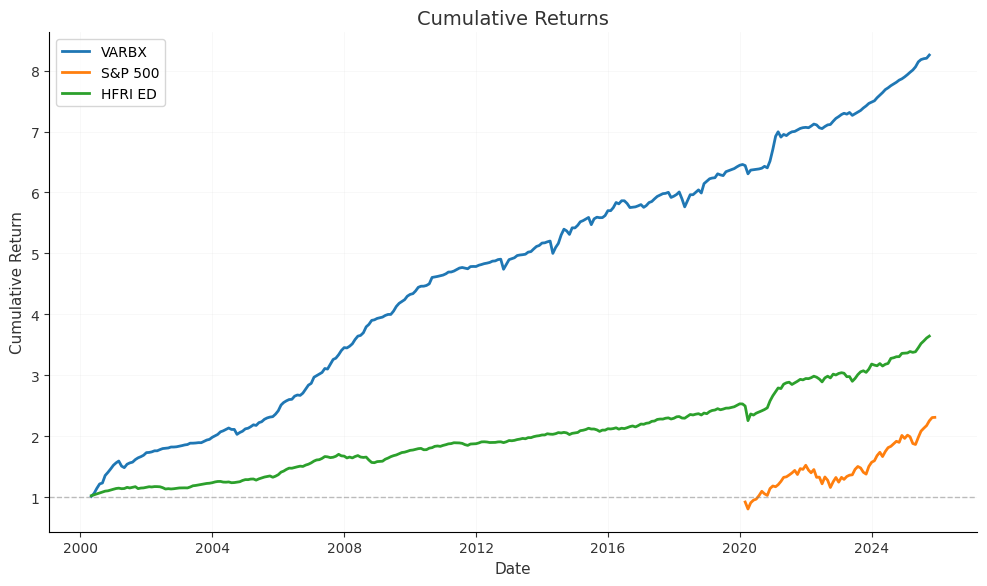

In [4]:
# Export cumulative returns plot
returns_dict = {
    "VARBX": varbx_returns_aligned,
    "S&P 500": sp500_returns_aligned,
    "HFRI ED": hfri_ed_returns_aligned
}

fig = plot_cumulative_returns(returns_dict)
save_figure(fig, "cumulative_returns", formats=["png", "pdf"])
print("Exported cumulative returns figure")


Exported drawdown figure


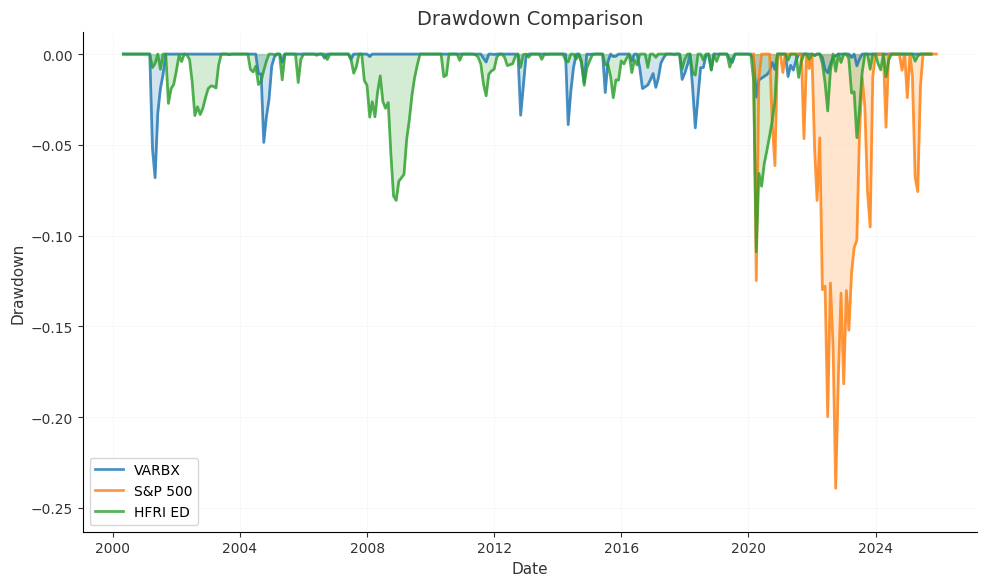

In [5]:
# Export drawdown plot for all three assets
varbx_drawdown = calculate_drawdown_series(varbx_returns_aligned)
sp500_drawdown = calculate_drawdown_series(sp500_returns_aligned)
hfri_ed_drawdown = calculate_drawdown_series(hfri_ed_returns_aligned)

drawdown_dict = {
    "VARBX": varbx_drawdown,
    "S&P 500": sp500_drawdown,
    "HFRI ED": hfri_ed_drawdown
}
fig = plot_drawdown(drawdown_dict, title="Drawdown Comparison")
save_figure(fig, "drawdown", formats=["png", "pdf"])
print("Exported drawdown figure")


## Export Comprehensive Metrics Visualizations


Exported comprehensive metrics table figure


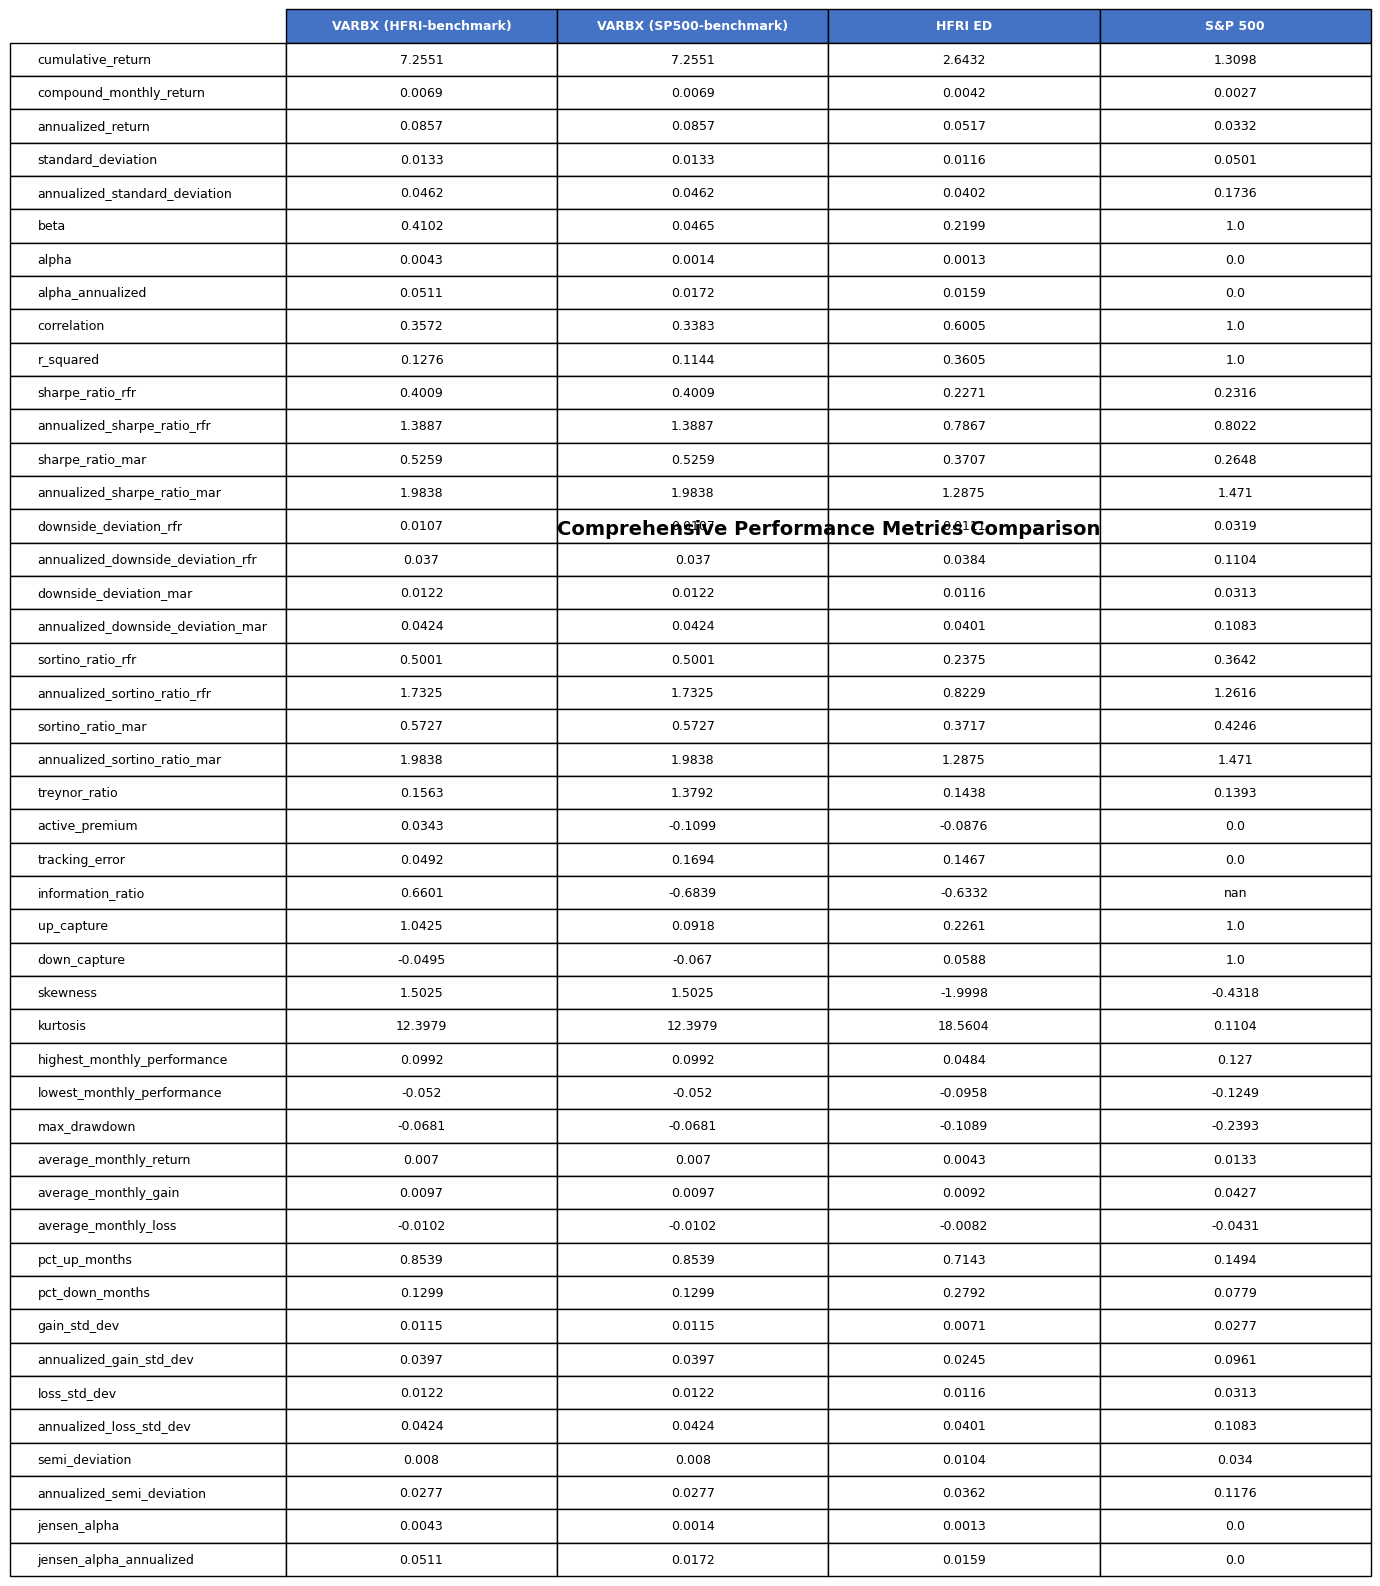

In [ ]:
# Export comprehensive metrics comparison table as figure
fig = plot_metrics_comparison_table(metrics_df, title="")
save_figure(fig, "comprehensive_metrics_table", formats=["png", "pdf"])
print("Exported comprehensive metrics table figure")


Exported up/down capture figure (VARBX vs HFRI ED)
Exported up/down capture figure (VARBX vs S&P 500)


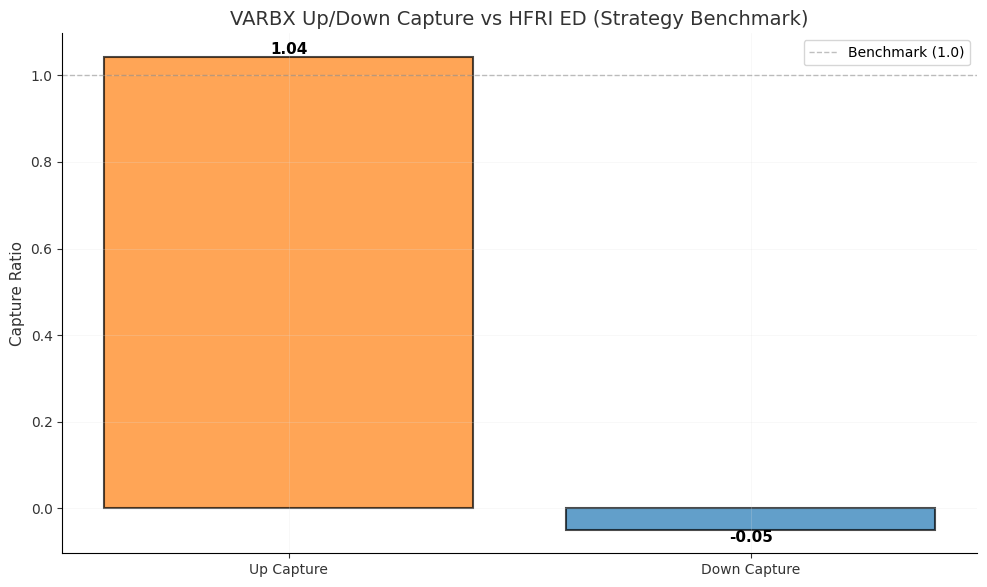

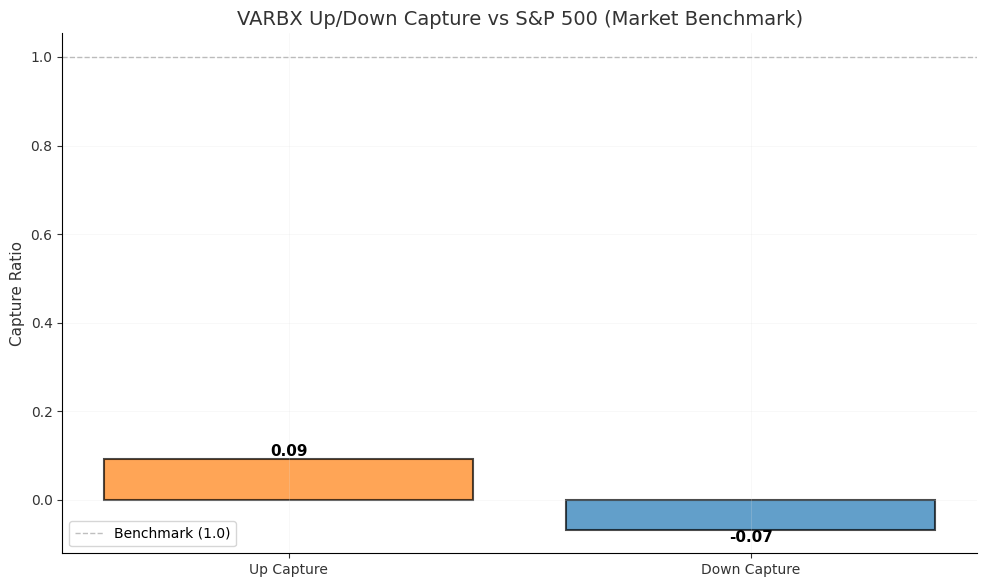

In [7]:
# Export up/down capture visualization for VARBX vs HFRI ED (strategy benchmark)
if "up_capture" in varbx_metrics_hfri and "down_capture" in varbx_metrics_hfri:
    fig = plot_up_down_capture(
        varbx_metrics_hfri["up_capture"],
        varbx_metrics_hfri["down_capture"],
        series_name="VARBX",
        title="VARBX Up/Down Capture vs HFRI ED (Strategy Benchmark)"
    )
    save_figure(fig, "up_down_capture_hfri", formats=["png", "pdf"])
    print("Exported up/down capture figure (VARBX vs HFRI ED)")

# Export up/down capture visualization for VARBX vs SP500 (market benchmark)
if "up_capture" in varbx_metrics_sp500 and "down_capture" in varbx_metrics_sp500:
    fig = plot_up_down_capture(
        varbx_metrics_sp500["up_capture"],
        varbx_metrics_sp500["down_capture"],
        series_name="VARBX",
        title="VARBX Up/Down Capture vs S&P 500 (Market Benchmark)"
    )
    save_figure(fig, "up_down_capture_sp500", formats=["png", "pdf"])
    print("Exported up/down capture figure (VARBX vs S&P 500)")


Exported VARBX return distribution figure
Exported HFRI ED return distribution figure


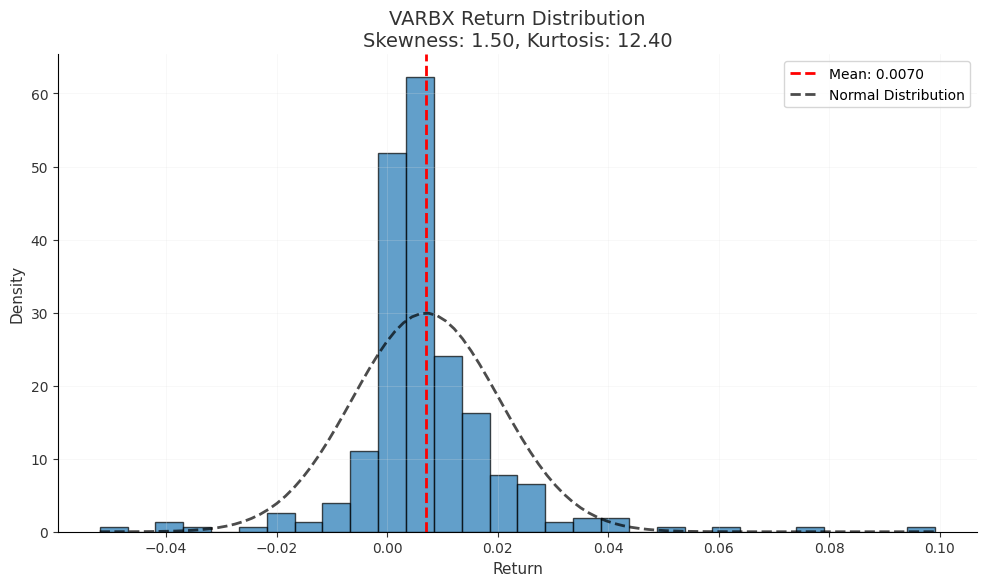

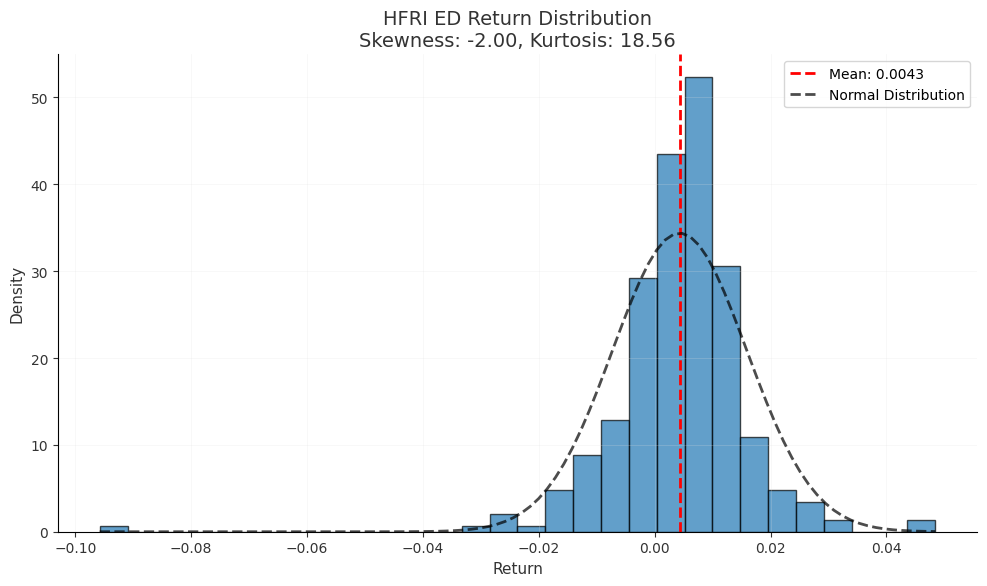

In [8]:
# Export return distribution plots
fig = plot_return_distribution(varbx_returns_aligned, title="VARBX Return Distribution")
save_figure(fig, "varbx_return_distribution", formats=["png", "pdf"])
print("Exported VARBX return distribution figure")

fig = plot_return_distribution(hfri_ed_returns_aligned, title="HFRI ED Return Distribution")
save_figure(fig, "hfri_ed_return_distribution", formats=["png", "pdf"])
print("Exported HFRI ED return distribution figure")


## Export Alpha/Beta Comparison: Market vs Strategy


Exported rolling alpha comparison figure
Exported rolling beta comparison figure


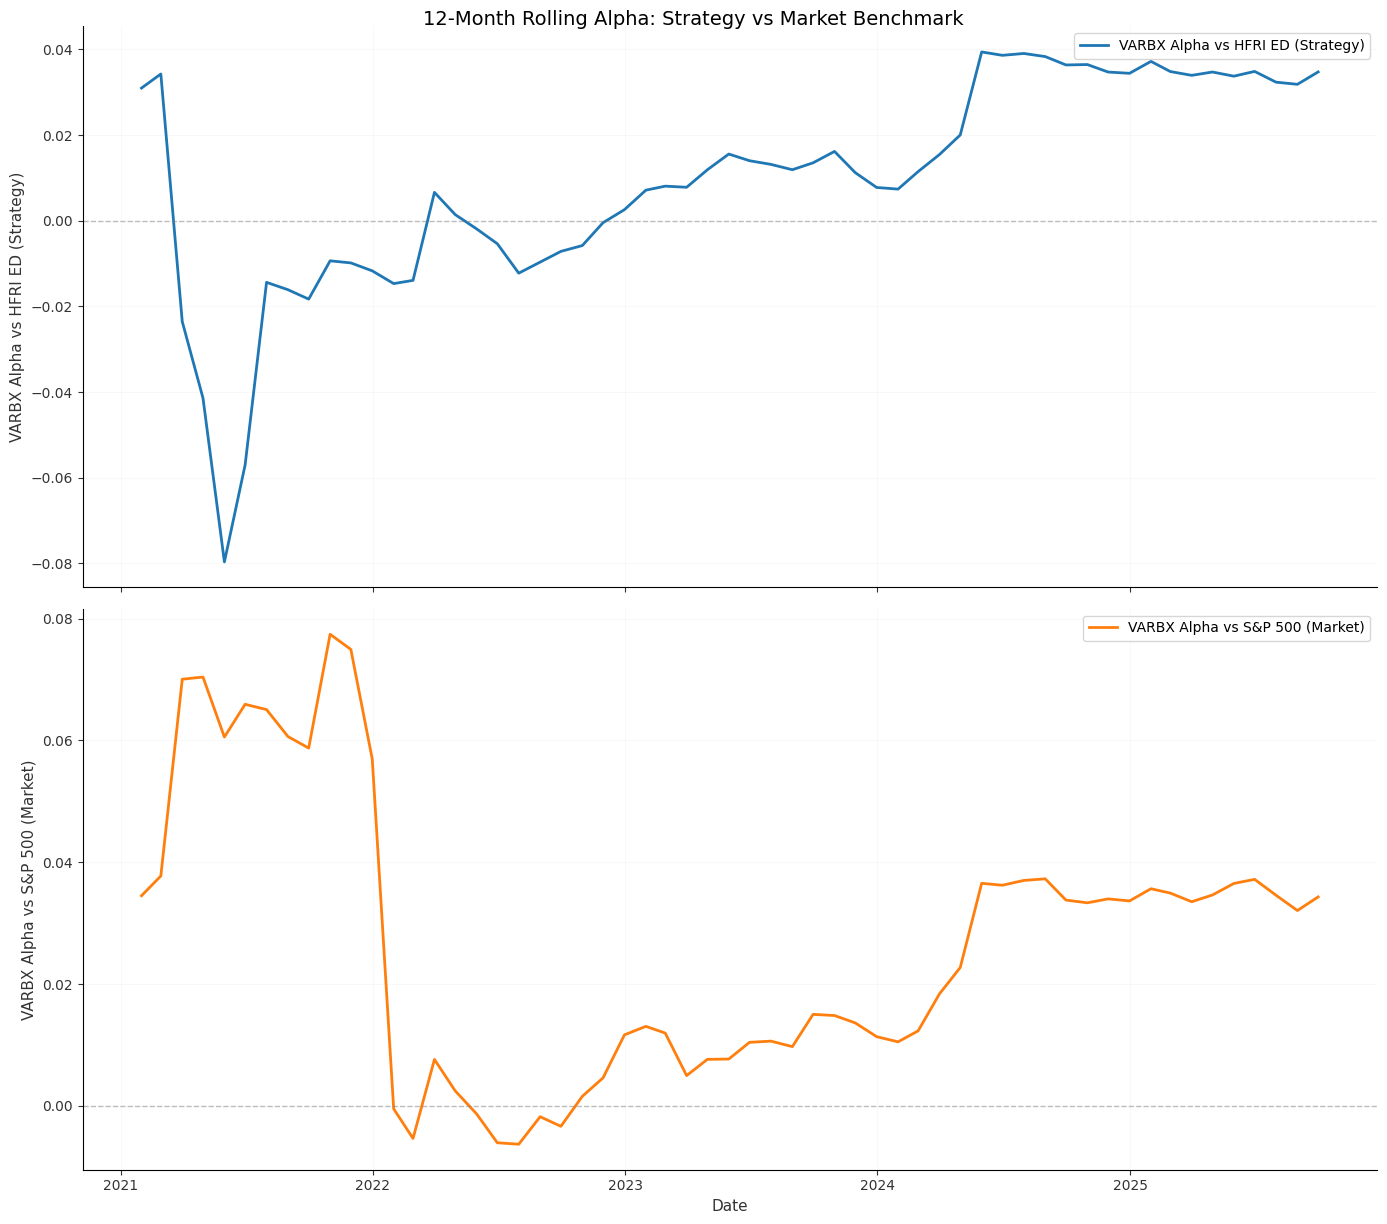

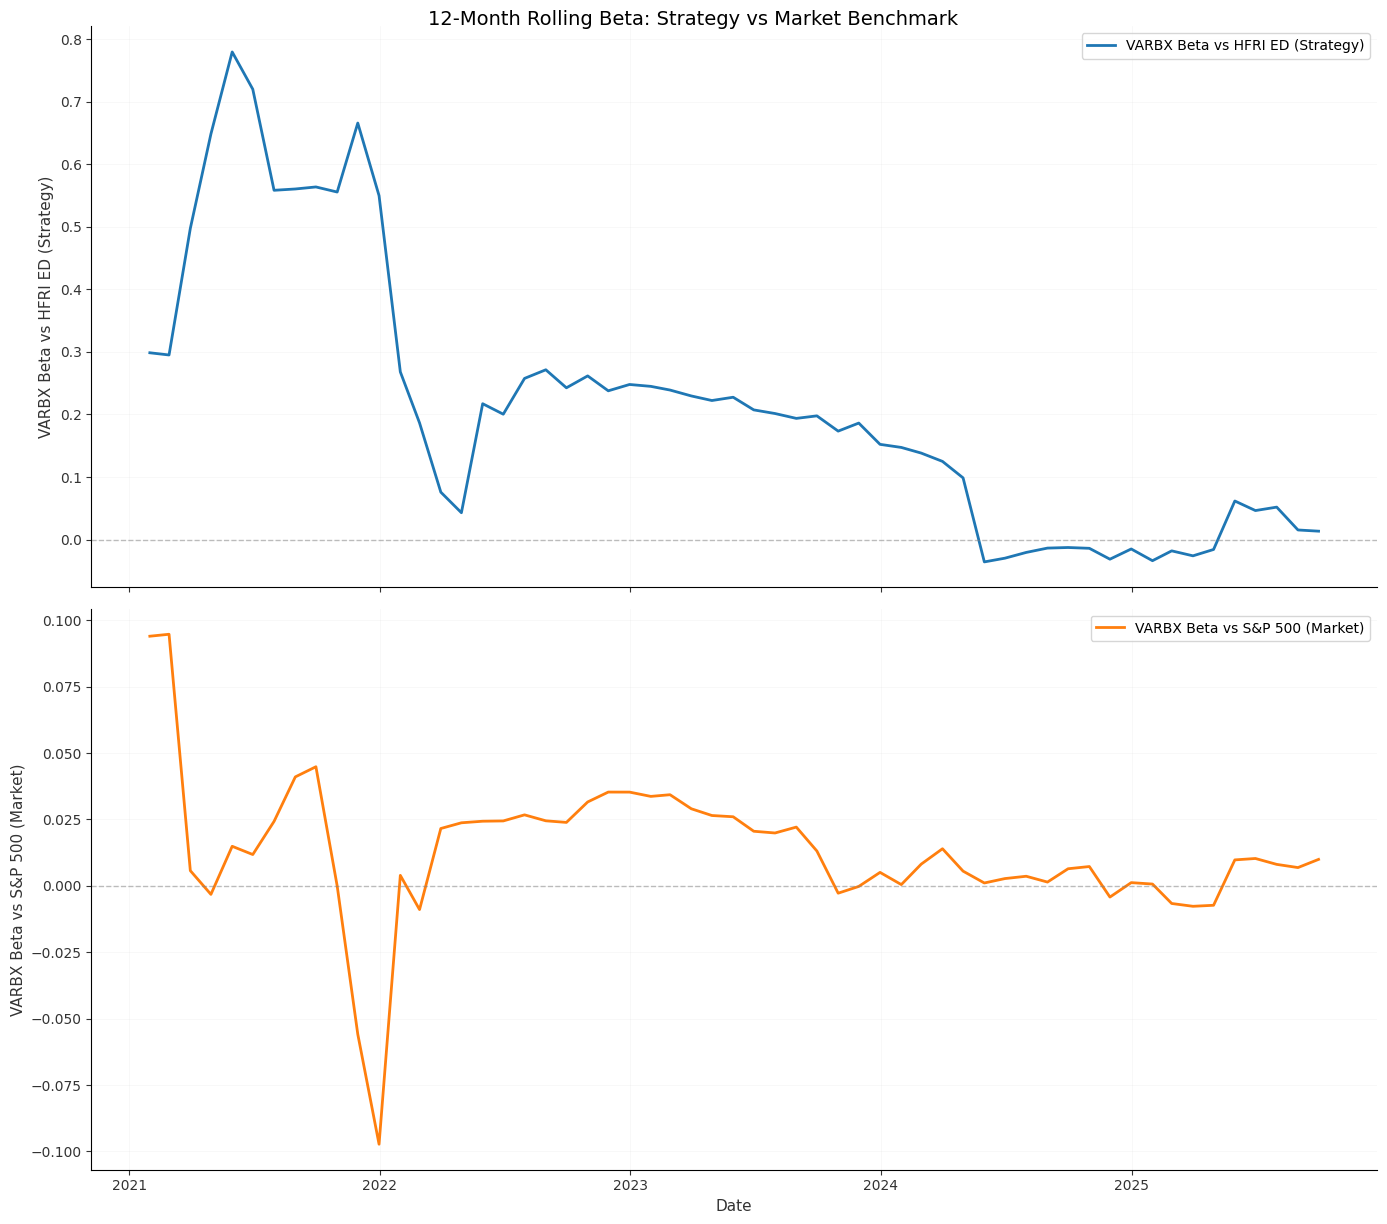

In [9]:
# Export rolling alpha/beta comparison charts
window = 12

# Calculate rolling alpha/beta for both benchmarks
rolling_ab_hfri = calculate_rolling_alpha_beta(
    varbx_returns_aligned,
    hfri_ed_returns_aligned,
    window=window
)

rolling_ab_sp500 = calculate_rolling_alpha_beta(
    varbx_aligned_for_sp500,
    sp500_for_varbx_benchmark,
    window=window
)

# Align by common dates for comparison
if len(rolling_ab_hfri) > 0 and len(rolling_ab_sp500) > 0:
    common_alpha_dates = rolling_ab_hfri.index.intersection(rolling_ab_sp500.index)
    if len(common_alpha_dates) > 0:
        # Plot rolling alpha comparison
        alpha_comparison_dict = {
            "VARBX Alpha vs HFRI ED (Strategy)": rolling_ab_hfri.loc[common_alpha_dates]["alpha_annualized"],
            "VARBX Alpha vs S&P 500 (Market)": rolling_ab_sp500.loc[common_alpha_dates]["alpha_annualized"]
        }
        fig = plot_rolling_metrics_comparison(alpha_comparison_dict, title=f"{window}-Month Rolling Alpha: Strategy vs Market Benchmark")
        save_figure(fig, "rolling_alpha_comparison", formats=["png", "pdf"])
        print("Exported rolling alpha comparison figure")
        
        # Plot rolling beta comparison
        beta_comparison_dict = {
            "VARBX Beta vs HFRI ED (Strategy)": rolling_ab_hfri.loc[common_alpha_dates]["beta"],
            "VARBX Beta vs S&P 500 (Market)": rolling_ab_sp500.loc[common_alpha_dates]["beta"]
        }
        fig = plot_rolling_metrics_comparison(beta_comparison_dict, title=f"{window}-Month Rolling Beta: Strategy vs Market Benchmark")
        save_figure(fig, "rolling_beta_comparison", formats=["png", "pdf"])
        print("Exported rolling beta comparison figure")


VARBX Alpha/Beta Comparison: Strategy vs Market Benchmark
                    VARBX vs HFRI ED (Strategy)  VARBX vs S&P 500 (Market)
Metric                                                                    
Alpha (Annualized)                       0.0511                     0.0172
Beta                                     0.4102                     0.0465
R-squared                                0.1276                     0.1144
Correlation                              0.3572                     0.3383
Exported alpha/beta comparison table
Exported alpha/beta comparison figure


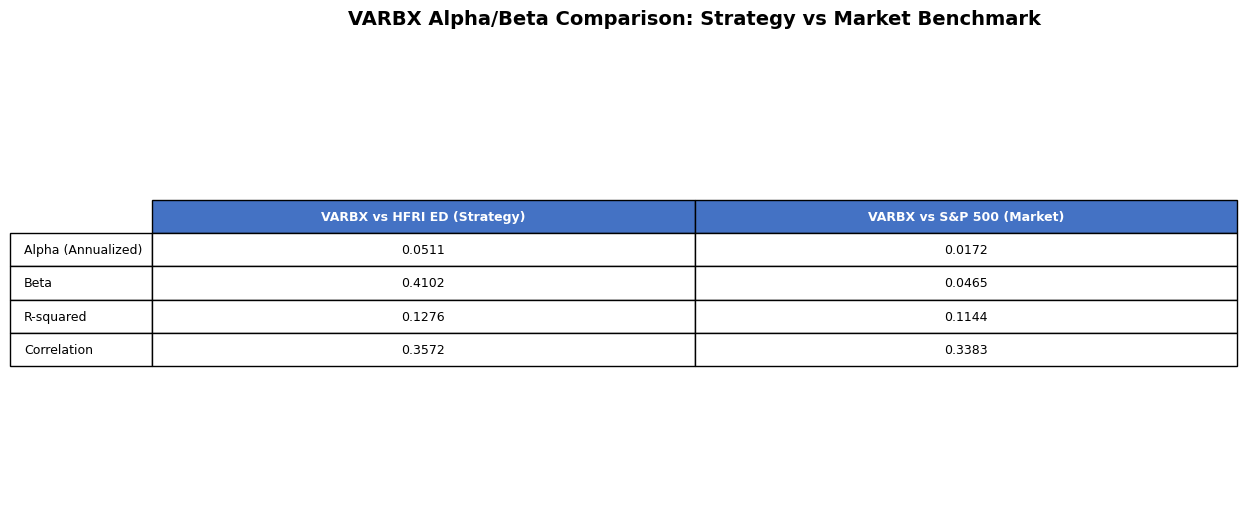

In [ ]:
# Create a comparison of alpha and beta for VARBX with both benchmarks
# Extract key metrics for comparison
alpha_beta_comparison_data = {
    "Metric": ["Alpha (Annualized)", "Beta", "R-squared", "Correlation"],
    "VARBX vs HFRI ED (Strategy)": [
        varbx_metrics_hfri.get("alpha_annualized", np.nan),
        varbx_metrics_hfri.get("beta", np.nan),
        varbx_metrics_hfri.get("r_squared", np.nan),
        varbx_metrics_hfri.get("correlation", np.nan)
    ],
    "VARBX vs S&P 500 (Market)": [
        varbx_metrics_sp500.get("alpha_annualized", np.nan),
        varbx_metrics_sp500.get("beta", np.nan),
        varbx_metrics_sp500.get("r_squared", np.nan),
        varbx_metrics_sp500.get("correlation", np.nan)
    ]
}

alpha_beta_comparison_df = pd.DataFrame(alpha_beta_comparison_data).set_index("Metric")
print("VARBX Alpha/Beta Comparison: Strategy vs Market Benchmark")
print(alpha_beta_comparison_df.round(4))

# Save comparison table
save_dataframe(alpha_beta_comparison_df, "varbx_alpha_beta_comparison", formats=["csv", "latex"])
print("Exported alpha/beta comparison table")

# Export as figure
fig = plot_metrics_comparison_table(alpha_beta_comparison_df, title="")
save_figure(fig, "varbx_alpha_beta_comparison", formats=["png", "pdf"])
print("Exported alpha/beta comparison figure")


Exported rolling Sharpe ratio comparison figure
Exported rolling alpha/beta figure (VARBX vs HFRI ED)
Exported rolling alpha/beta figure (VARBX vs S&P 500)


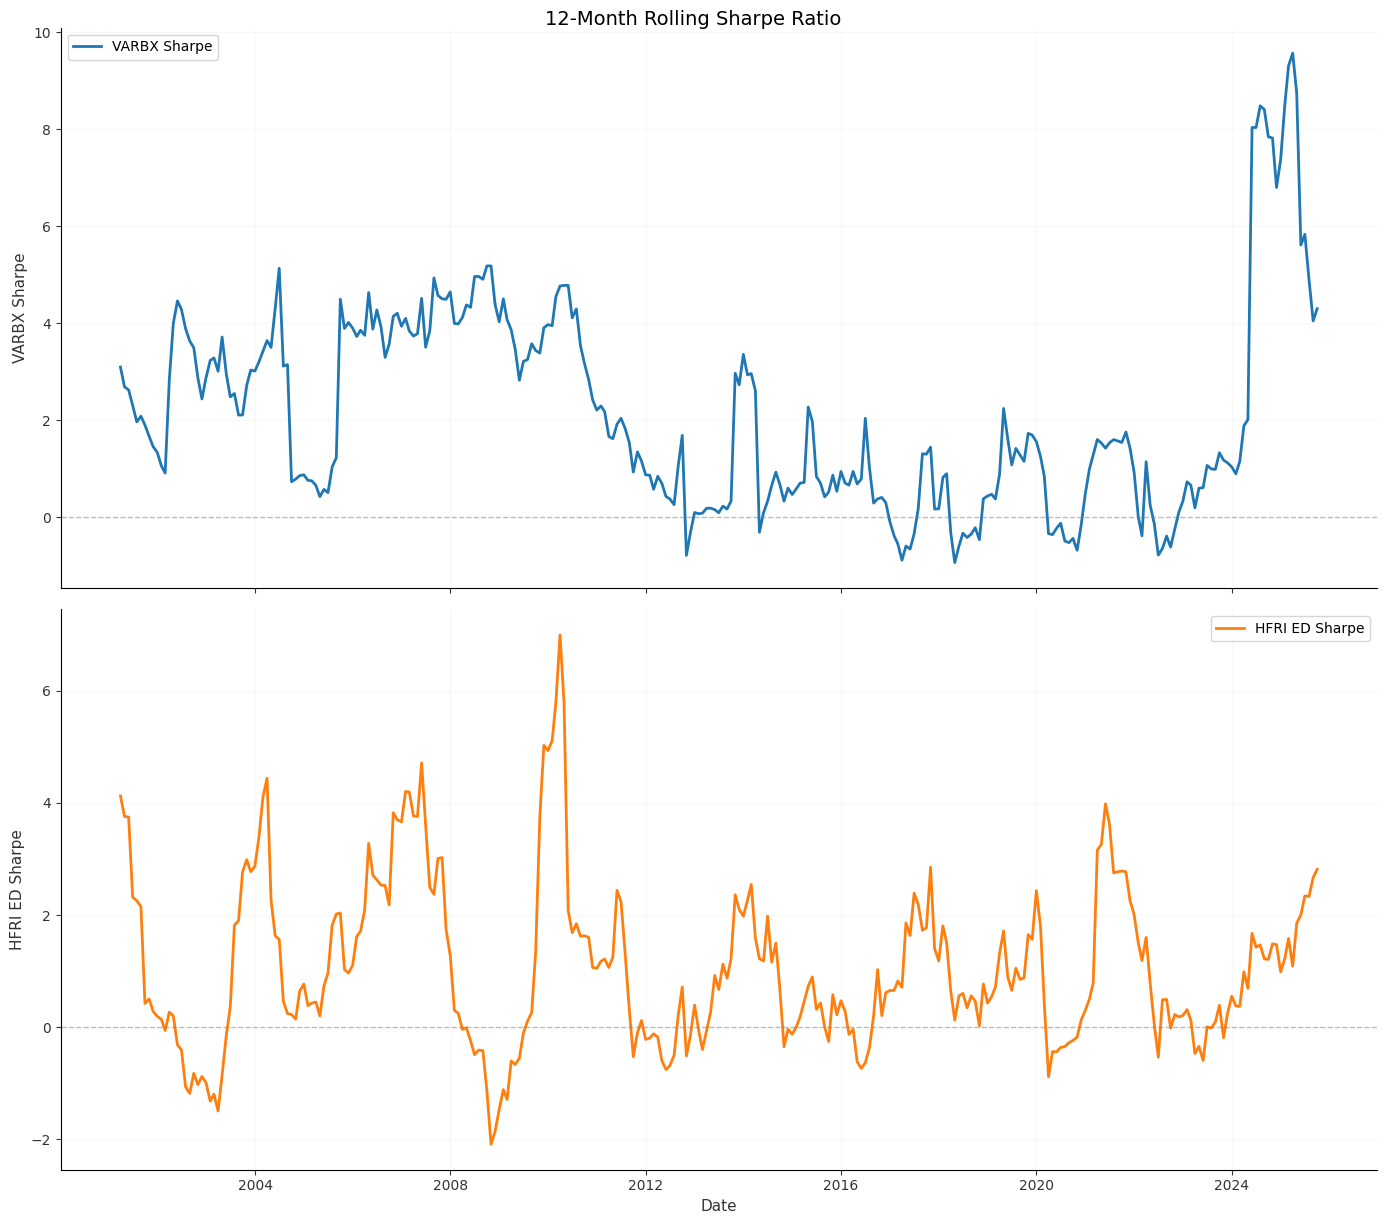

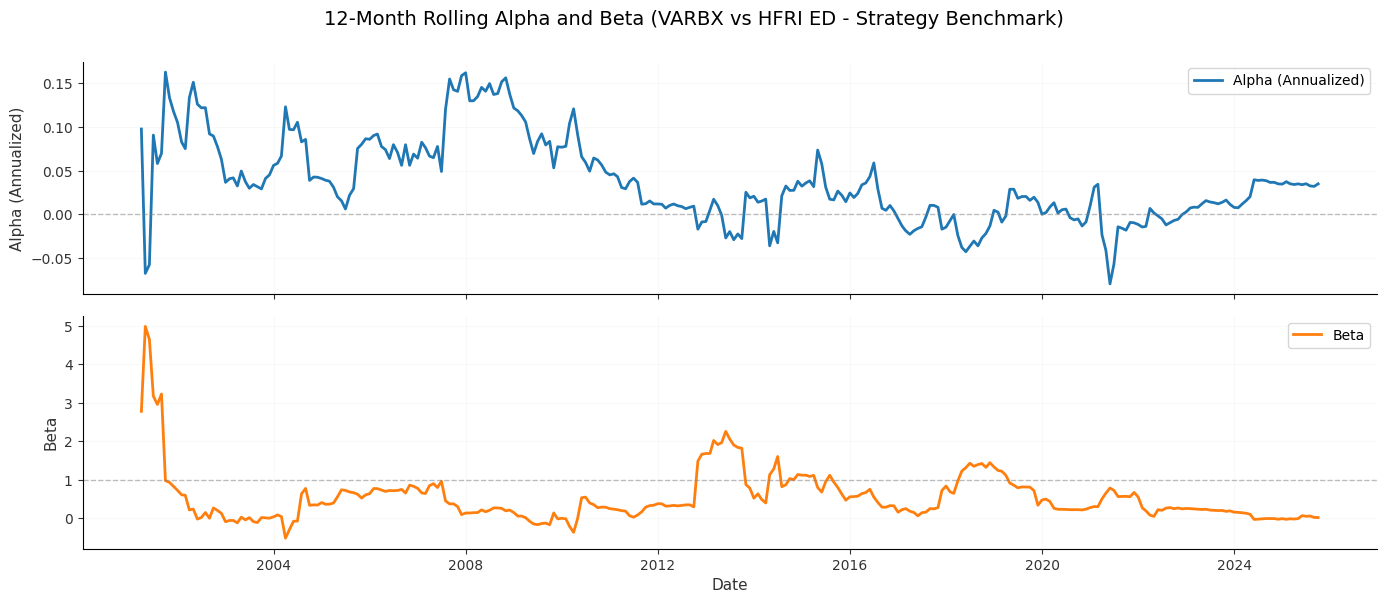

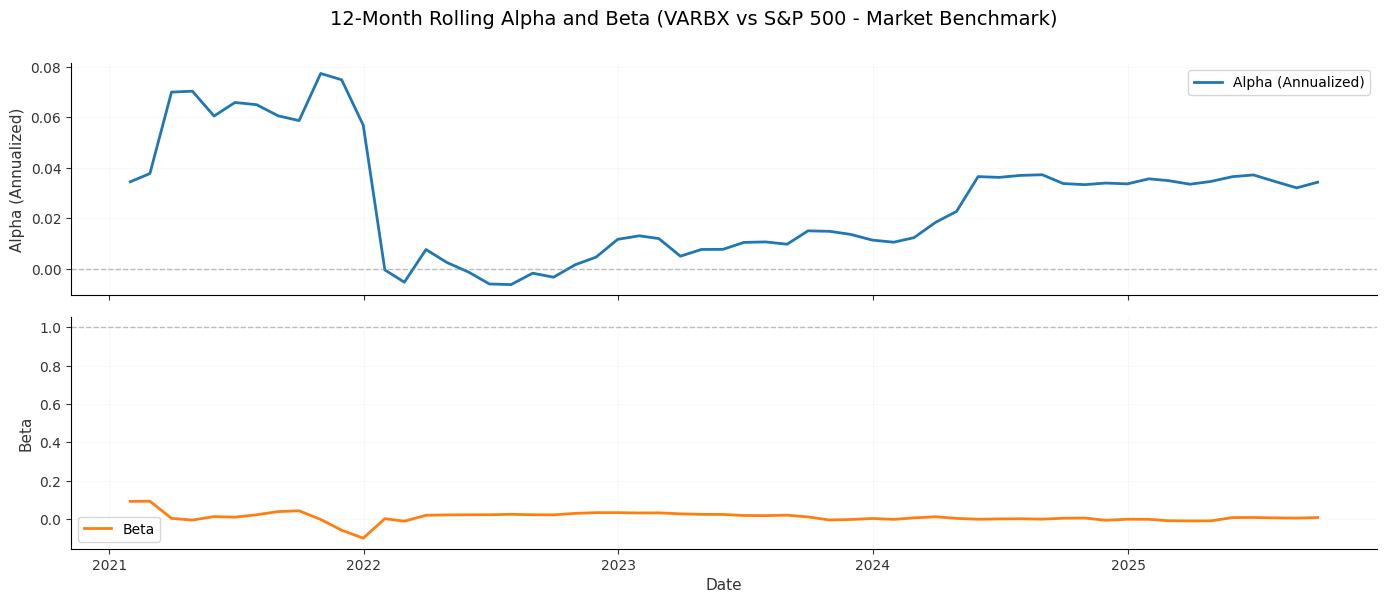

In [11]:
# Export rolling metrics time series
# Rolling Sharpe Ratio
window = 12
rolling_sharpe_varbx = calculate_rolling_sharpe(varbx_returns_aligned, window=window)
rolling_sharpe_hfri_ed = calculate_rolling_sharpe(hfri_ed_returns_aligned, window=window)
# Align by date
common_dates_rolling = rolling_sharpe_varbx.index.intersection(rolling_sharpe_hfri_ed.index)
if len(common_dates_rolling) > 0:
    rolling_sharpe_dict = {
        "VARBX Sharpe": rolling_sharpe_varbx.loc[common_dates_rolling],
        "HFRI ED Sharpe": rolling_sharpe_hfri_ed.loc[common_dates_rolling]
    }
    fig = plot_rolling_metrics_comparison(rolling_sharpe_dict, title=f"{window}-Month Rolling Sharpe Ratio")
    save_figure(fig, "rolling_sharpe_comparison", formats=["png", "pdf"])
    print("Exported rolling Sharpe ratio comparison figure")

# Rolling Alpha and Beta - VARBX vs HFRI ED (Strategy Benchmark)
rolling_ab_hfri = calculate_rolling_alpha_beta(
    varbx_returns_aligned,
    hfri_ed_returns_aligned,
    window=window
)
if len(rolling_ab_hfri) > 0:
    fig = plot_rolling_alpha_beta(rolling_ab_hfri, title=f"{window}-Month Rolling Alpha and Beta (VARBX vs HFRI ED - Strategy Benchmark)")
    save_figure(fig, "rolling_alpha_beta_hfri", formats=["png", "pdf"])
    print("Exported rolling alpha/beta figure (VARBX vs HFRI ED)")

# Rolling Alpha and Beta - VARBX vs SP500 (Market Benchmark)
rolling_ab_sp500 = calculate_rolling_alpha_beta(
    varbx_aligned_for_sp500,
    sp500_for_varbx_benchmark,
    window=window
)
if len(rolling_ab_sp500) > 0:
    fig = plot_rolling_alpha_beta(rolling_ab_sp500, title=f"{window}-Month Rolling Alpha and Beta (VARBX vs S&P 500 - Market Benchmark)")
    save_figure(fig, "rolling_alpha_beta_sp500", formats=["png", "pdf"])
    print("Exported rolling alpha/beta figure (VARBX vs S&P 500)")


## Export HFRI ED vs S&P 500 Comparison


Exported HFRI ED vs S&P 500 cumulative returns figure
Exported HFRI ED vs S&P 500 metrics comparison table
Exported HFRI ED vs S&P 500 metrics comparison figure


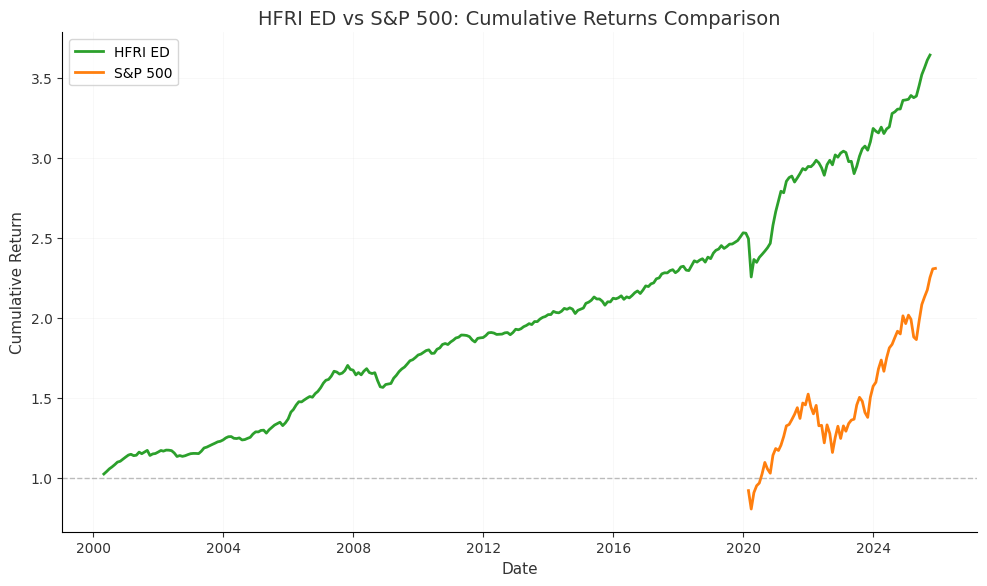

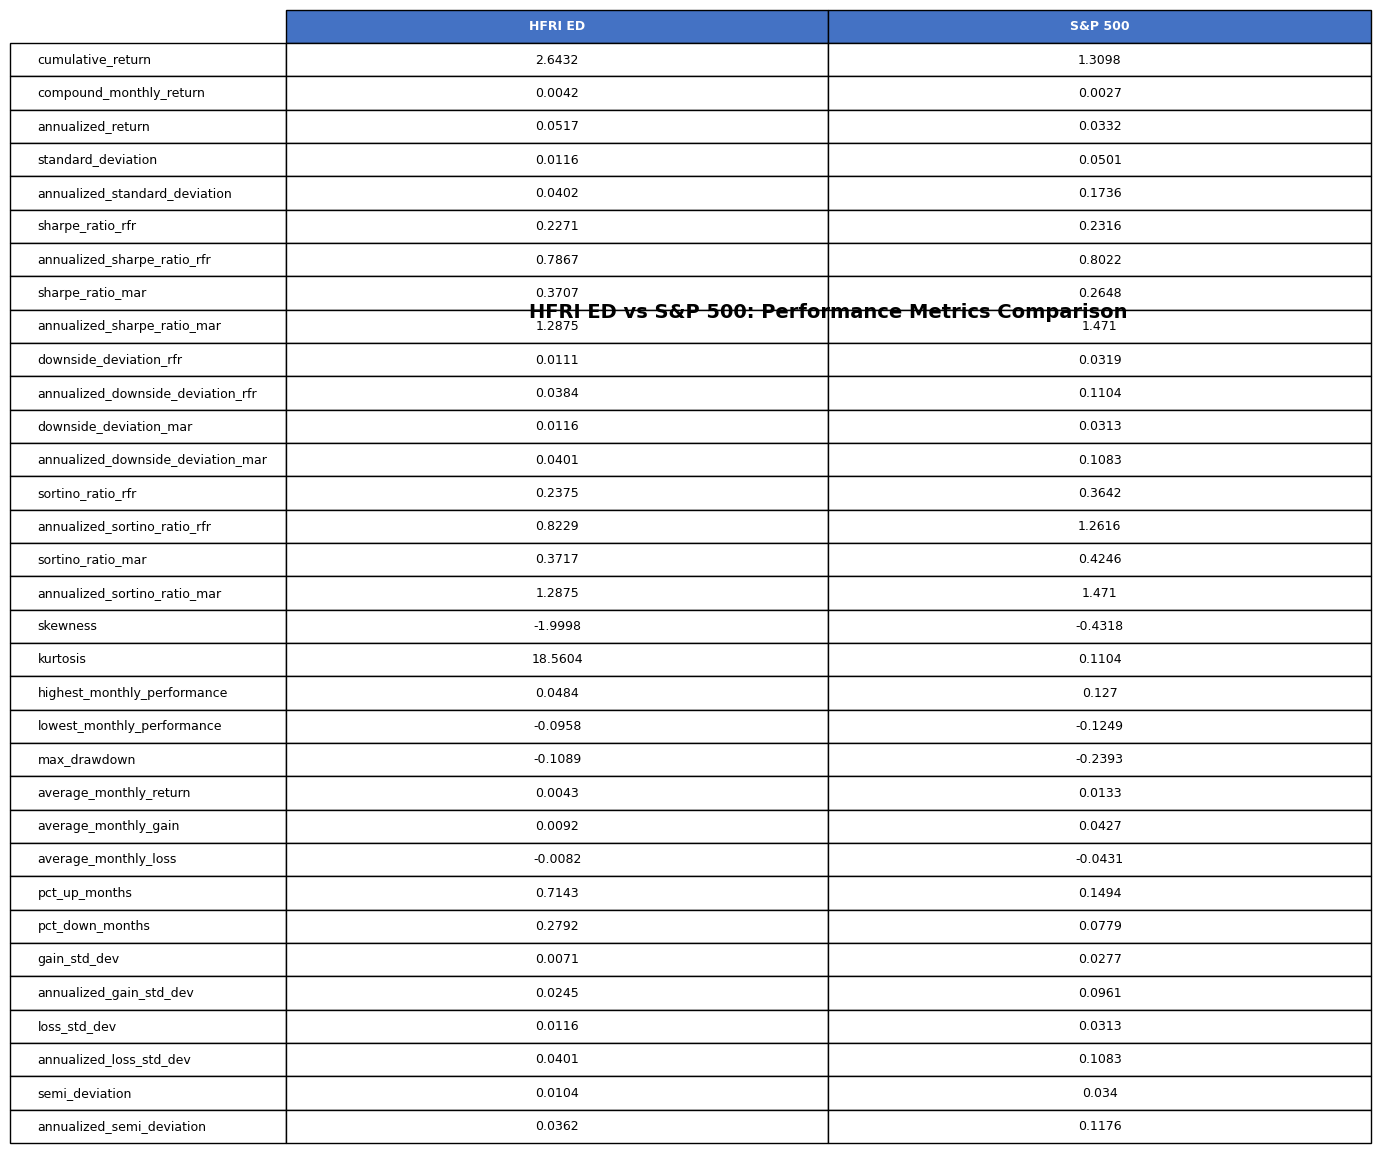

In [ ]:
# Export HFRI ED vs S&P 500 cumulative returns comparison
common_dates_hfri_sp500 = hfri_ed_returns_aligned.index.intersection(sp500_returns_aligned.index)
hfri_ed_for_comparison = hfri_ed_returns_aligned.loc[common_dates_hfri_sp500]
sp500_for_comparison = sp500_returns_aligned.loc[common_dates_hfri_sp500]

hfri_sp500_dict = {
    "HFRI ED": hfri_ed_for_comparison,
    "S&P 500": sp500_for_comparison
}
fig = plot_cumulative_returns(hfri_sp500_dict, title="HFRI ED vs S&P 500: Cumulative Returns Comparison")
save_figure(fig, "hfri_ed_sp500_cumulative_returns", formats=["png", "pdf"])
print("Exported HFRI ED vs S&P 500 cumulative returns figure")

# Export HFRI ED vs S&P 500 metrics comparison
hfri_ed_sp500_metrics = calculate_all_metrics(hfri_ed_for_comparison)
sp500_hfri_comparison_metrics = calculate_all_metrics(sp500_for_comparison)

hfri_sp500_metrics_df = pd.DataFrame({
    "HFRI ED": hfri_ed_sp500_metrics,
    "S&P 500": sp500_hfri_comparison_metrics
})

# Filter to only include metrics that exist
available_metrics_hfri_sp500 = [m for m in metric_order if m in hfri_sp500_metrics_df.index]
hfri_sp500_metrics_df = hfri_sp500_metrics_df.loc[available_metrics_hfri_sp500]

save_dataframe(hfri_sp500_metrics_df, "hfri_ed_sp500_metrics", formats=["csv", "latex"])
print("Exported HFRI ED vs S&P 500 metrics comparison table")

# Export as figure
fig = plot_metrics_comparison_table(hfri_sp500_metrics_df, title="")
save_figure(fig, "hfri_ed_sp500_metrics_table", formats=["png", "pdf"])
print("Exported HFRI ED vs S&P 500 metrics comparison figure")


Exported correlation matrix figure


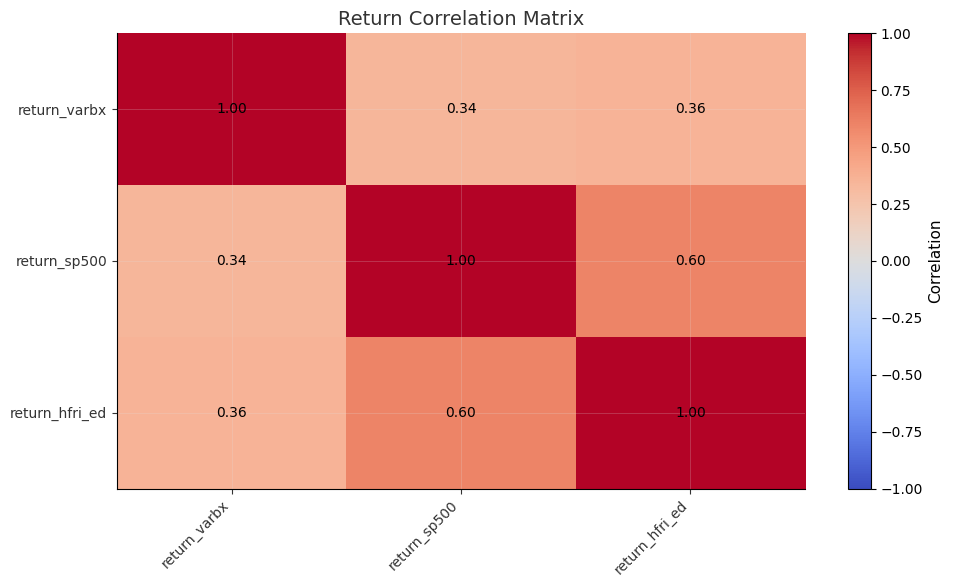

In [13]:
# Export correlation matrix
returns_only = returns_df[["return_varbx", "return_sp500", "return_hfri_ed"]].copy()
fig = plot_correlation_matrix(returns_only)
save_figure(fig, "correlation_matrix", formats=["png", "pdf"])
print("Exported correlation matrix figure")
